# Predictions of the likelihood of EPEs for Wellington region with 3 climate variables (without precipitation)
This notebook holds the modelling of EPEs for Wellington region with ERA5 reanalysis data for 3 climate variables temp,
surface pressure and total column water.

# Importing Libraries

In [1]:
# importing libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import xlrd
import seaborn as sns
import imblearn

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score, roc_auc_score

In [3]:
import sklearn
print('sklearn version {}'.format(sklearn.__version__))

sklearn version 0.24.0


# Reading Data

In [2]:
# Function to read array dataset and convert it into dataframe

def get_data(file):
    # path of different variables data for Wellington region 
    file_path = '/mnt/temp/Projects/Emergence/Data_Keep/epe/ERA5_1d/' + file + '/average/Wellington_1d.nc'
    # Reading array dataset
    df = xr.open_dataset(file_path)
    # Converting array dataset into dataframe
    data = df.to_dataframe()
    
    return data
   

In [3]:
# To get temperature data and change it's column name to 'temp' 
data_t = get_data('2T')
df_t = data_t.rename(columns={'data':'temp'})
df_t

,temp
time,
1996-01-01 00:00:00,290.853851
1996-01-01 01:00:00,291.417694
1996-01-01 02:00:00,292.178162
1996-01-01 03:00:00,292.575165
1996-01-01 04:00:00,292.863342
...,...
2020-04-30 19:00:00,285.855133
2020-04-30 20:00:00,287.536957
2020-04-30 21:00:00,287.438690


In [4]:
# To get surface pressure data and change it's column name to 'sp' 
data_s = get_data('SP')
df_sp = data_s.rename(columns={'data':'sp'})

# To get total column water data and change it's column name to 'tcw'
data_w = get_data('TCW')
df_tcw = data_w.rename(columns={'data':'tcw'})

# To get total percipitation
# data_prec = get_data('total_precipitation')
# df_prec = data_prec.rename(columns={'data':'precip'})

## Era5 DataFrames

In [5]:
# combine 4 dataframes
frames = [df_t, df_sp, df_tcw]
new_data = pd.concat(frames, axis=1, sort=False)
new_data

,temp,sp,tcw
time,,,
1996-01-01 00:00:00,290.853851,100175.007812,16.728743
1996-01-01 01:00:00,291.417694,100133.265625,17.180902
1996-01-01 02:00:00,292.178162,100123.757812,17.231808
1996-01-01 03:00:00,292.575165,100070.734375,16.735910
1996-01-01 04:00:00,292.863342,100008.296875,16.049551
...,...,...,...
2020-04-30 19:00:00,285.855133,99768.148438,7.431450
2020-04-30 20:00:00,287.536957,99792.570312,7.424390
2020-04-30 21:00:00,287.438690,99826.421875,7.393387


## Extreme events dataframe

In [2]:
# Reading maximum events
Extrm_data = pd.read_excel('/mnt/storage/Scratch/Fareeda/historical_ewes_tagged_202004241455_eventtiming.xlsx')
Extrm_data

ParserError: Expected 28 fields in line 258, saw 29

In [ ]:
# Reading extreme events data
Extrm_data = pd.read_csv('/mnt/storage/Scratch/Fareeda/historical_ewes_tagged_202004241455_eventtiming.csv')
Extrm_data

In [8]:
# Extracting two columns (event date and Wellington) from sheat dataframe
extm = Extrm_data[[ 'Wgn', 'Event Start', 'Event End', 'Event Duration']]
extm

,Wgn,Event Start,Event End,Event Duration
0,NaN,1996-03-29T21:00Z,1996-03-31T21:00Z,48
1,NaN,NaN,NaN,NaN
2,NaN,1996-07-09T21:00Z,1996-07-14T00:00Z,99
3,NaN,1996-07-13T21:00Z,1996-07-16T22:00Z,73
4,NaN,1996-07-30T21:00Z,1996-08-02T21:00Z,72
...,...,...,...,...
836,NaN,2019-11-30T22:00Z,2019-12-05T22:00Z,120
837,2R,2019-12-04T21:00Z,2019-12-08T20:00Z,95
838,NaN,NaN,NaN,NaN
839,NaN,2019-12-15T10:00Z,2019-12-19T18:00Z,104


In [9]:
# Removing null rows
extm1 = extm.dropna()
extm1

,Wgn,Event Start,Event End,Event Duration
8,3W,1996-09-30T19:00Z,1996-10-01T21:00Z,26
9,3R;3W,1996-10-11T18:00Z,1996-10-13T20:00Z,50
27,3R,1997-06-16T16:00Z,1997-06-18T03:00Z,35
35,2R;3W,1997-09-30T00:00Z,1997-10-05T20:00Z,140
49,3R,1998-02-23T17:00Z,1998-02-23T23:00Z,6
...,...,...,...,...
778,3W,2018-02-18T20:00Z,2018-02-21T20:00Z,72
791,2R,2018-06-10T20:00Z,2018-06-13T21:00Z,73
794,3R;3W,2018-07-06T13:00Z,2018-07-09T05:00Z,64
814,3R,2019-03-07T16:00Z,2019-03-08T23:00Z,31


In [10]:
# Selecting rows that has R in Wgn column
extm_R = extm1.loc[extm1['Wgn'].str.contains('R')]
extm_R

,Wgn,Event Start,Event End,Event Duration
9,3R;3W,1996-10-11T18:00Z,1996-10-13T20:00Z,50
27,3R,1997-06-16T16:00Z,1997-06-18T03:00Z,35
35,2R;3W,1997-09-30T00:00Z,1997-10-05T20:00Z,140
49,3R,1998-02-23T17:00Z,1998-02-23T23:00Z,6
53,3W;3R,1998-03-27T21:00Z,1998-03-30T21:00Z,72
...,...,...,...,...
773,3R;3W,2018-01-30T20:00Z,2018-02-03T02:00Z,78
791,2R,2018-06-10T20:00Z,2018-06-13T21:00Z,73
794,3R;3W,2018-07-06T13:00Z,2018-07-09T05:00Z,64
814,3R,2019-03-07T16:00Z,2019-03-08T23:00Z,31


In [11]:
# Changing date format 
import datetime
d1 = datetime.datetime.strptime("1996-10-11T18:00Z","%Y-%m-%dT%H:%SZ")

new_format = "%Y-%m-%d"
d1.strftime(new_format)



'1996-10-11'

In [12]:
for date in extm_R['Event End']:
    d2 = datetime.datetime.strptime(date,"%Y-%m-%dT%H:%SZ")
    
    d2.strftime(new_format)
   # print(date)
    

ValueError: time data 'one in Te Horo Beach Rd and another near the Mangaone Stream.\\""' does not match format '%Y-%m-%dT%H:%SZ'

In [310]:
# Checking date format 

for date in extm_R['Event End']:
#     d2 = datetime.datetime.strptime(date,"%Y-%m-%dT%H:%SZ")
    
#     d2.strftime(new_format)
    print(date)
    
    
    

1996-10-13T20:00Z
1997-06-18T03:00Z
1997-10-05T20:00Z
1998-02-23T23:00Z
1998-03-30T21:00Z
1998-06-14T01:00Z
1998-06-26T21:00Z
1998-07-02T21:00Z
1998-10-12T20:00Z
1998-10-20T20:00Z
1998-10-29T05:00Z
1999-03-23T21:00Z
1999-08-21T21:00Z
1999-11-12T20:00Z
1999-11-29T20:00Z
1999-12-19T20:00Z
2000-10-02T00:00Z
2000-10-02T21:00Z
2000-10-11T20:00Z
2001-11-23T20:00Z
2003-06-09T21:00Z
2003-10-03T23:00Z
2004-01-21T20:00Z
2004-02-01T21:00Z
2004-02-13T19:00Z
2004-02-16T20:00Z
2004-02-28T22:00Z
2004-04-06T23:00Z
2004-06-21T21:00Z
2005-01-08T00:00Z
2005-03-31T14:00Z
2005-07-14T21:00Z
2006-06-19T23:00Z
2006-07-06T21:00Z
2006-07-20T21:00Z
2006-08-26T21:00Z
2006-10-24T00:00Z
2006-11-17T23:00Z
2007-10-09T01:00Z
one in Te Horo Beach Rd and another near the Mangaone Stream.\""
2008-03-02T20:00Z
2008-07-12T21:00Z
2008-07-31T21:00Z
2008-08-15T21:00Z
2008-08-26T21:00Z
2008-10-08T13:00Z
2009-02-21T20:00Z
2009-07-23T22:00Z
2010-01-16T20:00Z
2010-01-24T18:00Z
2010-05-26T21:00Z
2011-01-24T00:00Z
2012-03-03T20:00Z

In [ ]:
pat = r'^[0-9]'
sh3['Event End'].str.contains('^[0-9]')

In [13]:
# Selecting rows of event start column that starts with 0-9
extm2 = extm_R.loc[extm_R['Event Start'].str.contains('^[0-9]')]
extm2

,Wgn,Event Start,Event End,Event Duration
9,3R;3W,1996-10-11T18:00Z,1996-10-13T20:00Z,50
27,3R,1997-06-16T16:00Z,1997-06-18T03:00Z,35
35,2R;3W,1997-09-30T00:00Z,1997-10-05T20:00Z,140
49,3R,1998-02-23T17:00Z,1998-02-23T23:00Z,6
53,3W;3R,1998-03-27T21:00Z,1998-03-30T21:00Z,72
...,...,...,...,...
773,3R;3W,2018-01-30T20:00Z,2018-02-03T02:00Z,78
791,2R,2018-06-10T20:00Z,2018-06-13T21:00Z,73
794,3R;3W,2018-07-06T13:00Z,2018-07-09T05:00Z,64
814,3R,2019-03-07T16:00Z,2019-03-08T23:00Z,31


In [14]:
new_data

,temp,sp,tcw
time,,,
1996-01-01 00:00:00,290.853851,100175.007812,16.728743
1996-01-01 01:00:00,291.417694,100133.265625,17.180902
1996-01-01 02:00:00,292.178162,100123.757812,17.231808
1996-01-01 03:00:00,292.575165,100070.734375,16.735910
1996-01-01 04:00:00,292.863342,100008.296875,16.049551
...,...,...,...
2020-04-30 19:00:00,285.855133,99768.148438,7.431450
2020-04-30 20:00:00,287.536957,99792.570312,7.424390
2020-04-30 21:00:00,287.438690,99826.421875,7.393387


In [15]:
# Function to convert date format
new_format1 = "%Y-%m-%d %H:%S:00"

import datetime
def convertDate(d):
     new_date = datetime.datetime.strptime(d,"%Y-%m-%dT%H:%SZ")
     #return new_date.date()
     return new_date.strftime(new_format1)
convertDate("2018-07-09T05:00Z")

'2018-07-09 05:00:00'

In [16]:
# changing date format of event start and event end columns 

extm2['Event_Start'] = extm2['Event Start'].apply(convertDate)
extm2['Event_End'] = extm2['Event End'].apply(convertDate)
extm2['Event_duration'] = extm2['Event Duration']
extm2

<ipython-input-16-e0fb1195607c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extm2['Event_Start'] = extm2['Event Start'].apply(convertDate)
<ipython-input-16-e0fb1195607c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extm2['Event_End'] = extm2['Event End'].apply(convertDate)
<ipython-input-16-e0fb1195607c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,Wgn,Event Start,Event End,Event Duration,Event_Start,Event_End,Event_duration
9,3R;3W,1996-10-11T18:00Z,1996-10-13T20:00Z,50,1996-10-11 18:00:00,1996-10-13 20:00:00,50
27,3R,1997-06-16T16:00Z,1997-06-18T03:00Z,35,1997-06-16 16:00:00,1997-06-18 03:00:00,35
35,2R;3W,1997-09-30T00:00Z,1997-10-05T20:00Z,140,1997-09-30 00:00:00,1997-10-05 20:00:00,140
49,3R,1998-02-23T17:00Z,1998-02-23T23:00Z,6,1998-02-23 17:00:00,1998-02-23 23:00:00,6
53,3W;3R,1998-03-27T21:00Z,1998-03-30T21:00Z,72,1998-03-27 21:00:00,1998-03-30 21:00:00,72
...,...,...,...,...,...,...,...
773,3R;3W,2018-01-30T20:00Z,2018-02-03T02:00Z,78,2018-01-30 20:00:00,2018-02-03 02:00:00,78
791,2R,2018-06-10T20:00Z,2018-06-13T21:00Z,73,2018-06-10 20:00:00,2018-06-13 21:00:00,73
794,3R;3W,2018-07-06T13:00Z,2018-07-09T05:00Z,64,2018-07-06 13:00:00,2018-07-09 05:00:00,64
814,3R,2019-03-07T16:00Z,2019-03-08T23:00Z,31,2019-03-07 16:00:00,2019-03-08 23:00:00,31


In [17]:
extm2.drop(['Event Start', 'Event End', 'Event Duration'], axis=1, inplace=True)
extm2

/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Wgn,Event_Start,Event_End,Event_duration
9,3R;3W,1996-10-11 18:00:00,1996-10-13 20:00:00,50
27,3R,1997-06-16 16:00:00,1997-06-18 03:00:00,35
35,2R;3W,1997-09-30 00:00:00,1997-10-05 20:00:00,140
49,3R,1998-02-23 17:00:00,1998-02-23 23:00:00,6
53,3W;3R,1998-03-27 21:00:00,1998-03-30 21:00:00,72
...,...,...,...,...
773,3R;3W,2018-01-30 20:00:00,2018-02-03 02:00:00,78
791,2R,2018-06-10 20:00:00,2018-06-13 21:00:00,73
794,3R;3W,2018-07-06 13:00:00,2018-07-09 05:00:00,64
814,3R,2019-03-07 16:00:00,2019-03-08 23:00:00,31


In [18]:
# Function to select rows from main data dataframe that lie between event start and end event columns of sh5 dataframe then calculate max, min amd mean of temp, sp, tcw and 
# precip variables of main data dataframe

def mask1(d):
    
    rows = new_data.loc[(new_data.index >= d.Event_Start) & (new_data.index <= d.Event_End)]
    d['temp_max'] = rows.temp.max()
    d['temp_max'] = rows.temp.max()
    d['temp_min'] = rows.temp.min()
    d['temp_mean'] = rows.temp.mean()
    d['sp_max'] = rows.sp.max()
    d['sp_min'] = rows.sp.min()
    d[ 'sp_mean'] = rows.sp.mean()
    d['tcw_max'] = rows.tcw.max()
    d['tcw_min'] = rows.tcw.min()
    d[ 'tcw_mean'] = rows.tcw.mean()
#     d['precip_max'] = rows.precip.max()
#     d[ 'precip_min'] = rows.precip.min()
#     d[ 'precip_mean'] = rows.precip.mean()
        
    return d 

In [19]:
# Dataframe 

extm_var = extm2.apply(mask1, axis=1)
extm_var

,Wgn,Event_Start,Event_End,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean
9,3R;3W,1996-10-11 18:00:00,1996-10-13 20:00:00,50,288.618622,282.704926,286.294952,97805.625000,96094.367188,97054.914062,35.010063,13.019938,21.753832
27,3R,1997-06-16 16:00:00,1997-06-18 03:00:00,35,285.822144,279.809784,283.655914,99098.367188,97454.796875,98313.453125,27.280825,16.356844,21.907808
35,2R;3W,1997-09-30 00:00:00,1997-10-05 20:00:00,140,287.890137,278.181488,283.411652,99210.210938,97215.984375,98005.500000,26.705261,7.335347,16.051527
49,3R,1998-02-23 17:00:00,1998-02-23 23:00:00,6,286.573242,285.419495,285.962830,97362.164062,97165.492188,97266.078125,29.321499,23.222336,26.541691
53,3W;3R,1998-03-27 21:00:00,1998-03-30 21:00:00,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771
...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,3R;3W,2018-01-30 20:00:00,2018-02-03 02:00:00,78,298.440948,286.338928,292.088409,98827.835938,96703.046875,97609.562500,42.292416,12.697303,23.392792
791,2R,2018-06-10 20:00:00,2018-06-13 21:00:00,73,286.613434,282.649567,285.050751,99729.414062,97756.929688,98599.742188,24.775269,12.002686,20.999605
794,3R;3W,2018-07-06 13:00:00,2018-07-09 05:00:00,64,287.612366,281.020782,284.966187,98885.164062,96459.312500,97622.101562,26.536886,12.414055,19.786707
814,3R,2019-03-07 16:00:00,2019-03-08 23:00:00,31,291.316040,286.588837,289.237793,99303.921875,98979.812500,99130.015625,35.256756,17.349186,29.034767


In [20]:
extm_df = extm_var.drop('Wgn', axis=1)
extm_df

,Event_Start,Event_End,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean
9,1996-10-11 18:00:00,1996-10-13 20:00:00,50,288.618622,282.704926,286.294952,97805.625000,96094.367188,97054.914062,35.010063,13.019938,21.753832
27,1997-06-16 16:00:00,1997-06-18 03:00:00,35,285.822144,279.809784,283.655914,99098.367188,97454.796875,98313.453125,27.280825,16.356844,21.907808
35,1997-09-30 00:00:00,1997-10-05 20:00:00,140,287.890137,278.181488,283.411652,99210.210938,97215.984375,98005.500000,26.705261,7.335347,16.051527
49,1998-02-23 17:00:00,1998-02-23 23:00:00,6,286.573242,285.419495,285.962830,97362.164062,97165.492188,97266.078125,29.321499,23.222336,26.541691
53,1998-03-27 21:00:00,1998-03-30 21:00:00,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771
...,...,...,...,...,...,...,...,...,...,...,...,...
773,2018-01-30 20:00:00,2018-02-03 02:00:00,78,298.440948,286.338928,292.088409,98827.835938,96703.046875,97609.562500,42.292416,12.697303,23.392792
791,2018-06-10 20:00:00,2018-06-13 21:00:00,73,286.613434,282.649567,285.050751,99729.414062,97756.929688,98599.742188,24.775269,12.002686,20.999605
794,2018-07-06 13:00:00,2018-07-09 05:00:00,64,287.612366,281.020782,284.966187,98885.164062,96459.312500,97622.101562,26.536886,12.414055,19.786707
814,2019-03-07 16:00:00,2019-03-08 23:00:00,31,291.316040,286.588837,289.237793,99303.921875,98979.812500,99130.015625,35.256756,17.349186,29.034767


In [21]:
extm_df['Label'] =1


### Rain only dataframe (label 1)

In [22]:
extm_df

,Event_Start,Event_End,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,Label
9,1996-10-11 18:00:00,1996-10-13 20:00:00,50,288.618622,282.704926,286.294952,97805.625000,96094.367188,97054.914062,35.010063,13.019938,21.753832,1
27,1997-06-16 16:00:00,1997-06-18 03:00:00,35,285.822144,279.809784,283.655914,99098.367188,97454.796875,98313.453125,27.280825,16.356844,21.907808,1
35,1997-09-30 00:00:00,1997-10-05 20:00:00,140,287.890137,278.181488,283.411652,99210.210938,97215.984375,98005.500000,26.705261,7.335347,16.051527,1
49,1998-02-23 17:00:00,1998-02-23 23:00:00,6,286.573242,285.419495,285.962830,97362.164062,97165.492188,97266.078125,29.321499,23.222336,26.541691,1
53,1998-03-27 21:00:00,1998-03-30 21:00:00,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,2018-01-30 20:00:00,2018-02-03 02:00:00,78,298.440948,286.338928,292.088409,98827.835938,96703.046875,97609.562500,42.292416,12.697303,23.392792,1
791,2018-06-10 20:00:00,2018-06-13 21:00:00,73,286.613434,282.649567,285.050751,99729.414062,97756.929688,98599.742188,24.775269,12.002686,20.999605,1
794,2018-07-06 13:00:00,2018-07-09 05:00:00,64,287.612366,281.020782,284.966187,98885.164062,96459.312500,97622.101562,26.536886,12.414055,19.786707,1
814,2019-03-07 16:00:00,2019-03-08 23:00:00,31,291.316040,286.588837,289.237793,99303.921875,98979.812500,99130.015625,35.256756,17.349186,29.034767,1


## Not extreme events

In [ ]:
# Generating samples for label 0 (not raining events)

In [23]:
num_zero_samples = 2600

In [25]:
# Generating start dates from main data index of 10000 size and event durations from sh6 data frame of size 10000
np.random.seed(42)
zero_dates = np.random.choice(new_data.index, num_zero_samples, replace=False)
durations = np.random.choice(extm_df['Event_duration'].values, num_zero_samples, replace=True)

In [26]:
# Creating a dataframe 
np.random.seed(42)
dat = {'Event_duration' : durations, 'Event_Start' : zero_dates}
not_extm = pd.DataFrame( data=dat)

not_extm

,Event_duration,Event_Start
0,105,1998-08-03 04:00:00
1,73,2002-10-05 03:00:00
2,123,2004-12-11 02:00:00
3,56,2015-07-08 08:00:00
4,72,2011-12-21 18:00:00
...,...,...
2595,72,2006-07-13 14:00:00
2596,81,2004-05-27 04:00:00
2597,123,2012-12-25 15:00:00
2598,140,2017-01-07 18:00:00


In [68]:
df.Start_date[4] + pd.DateOffset(113)

Timestamp('2006-01-26 21:00:00')

In [27]:
# Function to compute event end dates
def event1(d):
    d['Event_End'] = d.Event_Start +  pd.Timedelta(d.Event_duration, 'h')
    return d

In [28]:
# creating new dataframe with event end column by applying event1 fucntion
not_extm1 = not_extm.apply(event1, axis=1)
not_extm1

,Event_duration,Event_Start,Event_End
0,105,1998-08-03 04:00:00,1998-08-07 13:00:00
1,73,2002-10-05 03:00:00,2002-10-08 04:00:00
2,123,2004-12-11 02:00:00,2004-12-16 05:00:00
3,56,2015-07-08 08:00:00,2015-07-10 16:00:00
4,72,2011-12-21 18:00:00,2011-12-24 18:00:00
...,...,...,...
2595,72,2006-07-13 14:00:00,2006-07-16 14:00:00
2596,81,2004-05-27 04:00:00,2004-05-30 13:00:00
2597,123,2012-12-25 15:00:00,2012-12-30 18:00:00
2598,140,2017-01-07 18:00:00,2017-01-13 14:00:00


In [29]:
# To check overlap

mask = np.zeros(len(not_extm1), dtype=np.bool)
for n, row in extm_df.iterrows():
    m_row = (not_extm1['Event_Start'] <= row['Event_End']) & (not_extm1['Event_End'] >= row['Event_Start'])
    mask = mask | m_row

In [30]:
not_extm1_no_overlap = not_extm1[~mask]

In [31]:
not_extm1_no_overlap

,Event_duration,Event_Start,Event_End
0,105,1998-08-03 04:00:00,1998-08-07 13:00:00
1,73,2002-10-05 03:00:00,2002-10-08 04:00:00
2,123,2004-12-11 02:00:00,2004-12-16 05:00:00
3,56,2015-07-08 08:00:00,2015-07-10 16:00:00
4,72,2011-12-21 18:00:00,2011-12-24 18:00:00
...,...,...,...
2594,50,1998-08-19 09:00:00,1998-08-21 11:00:00
2595,72,2006-07-13 14:00:00,2006-07-16 14:00:00
2596,81,2004-05-27 04:00:00,2004-05-30 13:00:00
2597,123,2012-12-25 15:00:00,2012-12-30 18:00:00


In [32]:
# Computing max, min amd mean values of each variable(temp, sp, tcw, percip) by checking start event and end event date and by applying mask1 function
not_extm_df = not_extm1_no_overlap.apply(mask1, axis=1)
not_extm_df

,Event_duration,Event_Start,Event_End,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean
0,105,1998-08-03 04:00:00,1998-08-07 13:00:00,286.354614,272.645142,281.273010,100836.695312,99308.710938,100065.187500,21.727236,4.960542,9.947332
1,73,2002-10-05 03:00:00,2002-10-08 04:00:00,284.671082,278.370544,280.910248,100400.609375,98919.109375,99904.070312,10.805573,6.071237,8.300861
2,123,2004-12-11 02:00:00,2004-12-16 05:00:00,291.960480,281.921234,286.429565,98044.867188,96521.601562,97348.320312,29.243023,11.898599,17.230324
3,56,2015-07-08 08:00:00,2015-07-10 16:00:00,280.507355,275.158386,277.725677,99845.421875,98278.390625,99194.523438,9.921685,6.575221,7.773457
4,72,2011-12-21 18:00:00,2011-12-24 18:00:00,292.543427,282.432587,287.257965,100220.664062,99553.328125,99875.656250,15.446160,8.531630,12.562784
...,...,...,...,...,...,...,...,...,...,...,...,...
2594,50,1998-08-19 09:00:00,1998-08-21 11:00:00,281.792053,275.782440,278.602478,99368.367188,97608.195312,98373.656250,10.546610,6.497055,8.737724
2595,72,2006-07-13 14:00:00,2006-07-16 14:00:00,286.311432,276.663635,282.944641,100162.820312,98226.132812,99449.882812,22.540861,7.756122,13.749166
2596,81,2004-05-27 04:00:00,2004-05-30 13:00:00,287.524567,280.761444,284.264801,99213.757812,96451.304688,97349.765625,28.426065,10.514742,15.045135
2597,123,2012-12-25 15:00:00,2012-12-30 18:00:00,296.369568,286.733978,290.198303,99638.351562,97652.000000,98741.484375,40.632042,11.627449,28.728510


### Not extreme dataframe

In [33]:
not_extm_df['Label'] = 0
not_extm_df

,Event_duration,Event_Start,Event_End,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,Label
0,105,1998-08-03 04:00:00,1998-08-07 13:00:00,286.354614,272.645142,281.273010,100836.695312,99308.710938,100065.187500,21.727236,4.960542,9.947332,0
1,73,2002-10-05 03:00:00,2002-10-08 04:00:00,284.671082,278.370544,280.910248,100400.609375,98919.109375,99904.070312,10.805573,6.071237,8.300861,0
2,123,2004-12-11 02:00:00,2004-12-16 05:00:00,291.960480,281.921234,286.429565,98044.867188,96521.601562,97348.320312,29.243023,11.898599,17.230324,0
3,56,2015-07-08 08:00:00,2015-07-10 16:00:00,280.507355,275.158386,277.725677,99845.421875,98278.390625,99194.523438,9.921685,6.575221,7.773457,0
4,72,2011-12-21 18:00:00,2011-12-24 18:00:00,292.543427,282.432587,287.257965,100220.664062,99553.328125,99875.656250,15.446160,8.531630,12.562784,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,50,1998-08-19 09:00:00,1998-08-21 11:00:00,281.792053,275.782440,278.602478,99368.367188,97608.195312,98373.656250,10.546610,6.497055,8.737724,0
2595,72,2006-07-13 14:00:00,2006-07-16 14:00:00,286.311432,276.663635,282.944641,100162.820312,98226.132812,99449.882812,22.540861,7.756122,13.749166,0
2596,81,2004-05-27 04:00:00,2004-05-30 13:00:00,287.524567,280.761444,284.264801,99213.757812,96451.304688,97349.765625,28.426065,10.514742,15.045135,0
2597,123,2012-12-25 15:00:00,2012-12-30 18:00:00,296.369568,286.733978,290.198303,99638.351562,97652.000000,98741.484375,40.632042,11.627449,28.728510,0


# Data split

In [34]:
# Dividing sh8  dataframe into 70% training data and 30% test data

ext_train = extm_df.sample(frac=0.7, random_state=42) #random state is a seed value
ext_test = extm_df.drop(ext_train.index)
len(ext_train), len(ext_test)

(48, 21)

In [35]:
# Dividing df2 dataframe into 70% training and 305 test data

notext_train = not_extm_df.sample(frac=0.7, random_state=42)
notext_test = not_extm_df.drop(notext_train.index)
len(notext_train), len(notext_test)

(1729, 741)

In [36]:
# Combine both train datasets
frame = [ext_train, notext_train]
train_data = pd.concat(frame)
train_data


,Event_Start,Event_End,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,Label
221,2004-01-18 11:00:00,2004-01-21 20:00:00,81,292.467804,283.668335,287.631134,99021.195312,98395.375000,98692.726562,40.826145,18.888306,25.592831,1
9,1996-10-11 18:00:00,1996-10-13 20:00:00,50,288.618622,282.704926,286.294952,97805.625000,96094.367188,97054.914062,35.010063,13.019938,21.753832,1
481,2010-01-11 16:00:00,2010-01-16 20:00:00,124,293.553558,281.030914,286.365265,98894.265625,97843.953125,98486.531250,35.116009,10.270416,22.108883,1
53,1998-03-27 21:00:00,1998-03-30 21:00:00,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,1
612,2013-06-16 21:00:00,2013-06-22 21:00:00,144,287.041748,277.368927,282.211304,98925.601562,95370.914062,96993.570312,21.331705,9.840097,16.079870,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,2015-12-28 02:00:00,2015-12-31 18:00:00,88,292.299255,281.537231,287.085815,99862.875000,97675.039062,98590.257812,23.810335,7.078931,13.448935,0
104,2003-11-02 09:00:00,2003-11-04 17:00:00,56,286.080505,277.494354,283.253510,99341.039062,96611.601562,97740.484375,15.266307,8.068126,10.247030,0
1843,2006-03-28 04:00:00,2006-03-31 13:00:00,81,289.033051,279.732361,284.879272,99659.585938,98295.359375,99156.328125,27.725428,8.278473,14.109967,0
848,2011-03-08 20:00:00,2011-03-12 21:00:00,97,291.965271,280.987152,287.307953,100489.742188,99183.687500,99734.601562,26.745785,12.472096,16.474991,0


In [37]:
# Combine both test datasets
frames = [ext_test, notext_test]
test_data = pd.concat(frames)
test_data


,Event_Start,Event_End,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,Label
27,1997-06-16 16:00:00,1997-06-18 03:00:00,35,285.822144,279.809784,283.655914,99098.367188,97454.796875,98313.453125,27.280825,16.356844,21.907808,1
35,1997-09-30 00:00:00,1997-10-05 20:00:00,140,287.890137,278.181488,283.411652,99210.210938,97215.984375,98005.500000,26.705261,7.335347,16.051527,1
85,1999-03-22 21:00:00,1999-03-23 21:00:00,24,293.966827,285.571136,290.807404,99411.882812,98418.953125,98749.562500,38.518211,14.067528,27.876787,1
107,1999-11-26 20:00:00,1999-11-29 20:00:00,72,290.394135,281.091583,285.410767,98418.554688,97006.632812,97669.914062,27.849125,8.343957,20.657993,1
195,2003-06-05 20:00:00,2003-06-09 21:00:00,97,289.299988,282.121155,285.669952,98707.375000,96882.328125,98086.796875,28.419785,7.233722,16.929239,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,2002-03-22 11:00:00,2002-03-25 12:00:00,73,292.947693,280.257233,286.870514,99574.773438,98960.882812,99332.304688,21.433033,7.939862,13.126389,0
2584,1999-11-30 21:00:00,1999-12-06 00:00:00,123,292.360168,283.835236,288.032440,99256.960938,98296.289062,98866.492188,29.277912,10.942727,20.998795,0
2588,2008-11-06 07:00:00,2008-11-11 00:00:00,113,290.110779,276.248322,283.826813,100091.812500,97511.273438,99374.046875,25.062189,7.154927,14.175885,0
2591,2017-09-27 20:00:00,2017-10-01 12:00:00,88,287.415344,280.828217,284.273163,98925.328125,96398.398438,97632.648438,21.505634,8.766189,13.713187,0


In [38]:
X_train = train_data.drop(['Event_Start', 'Event_End', 'Label'], axis=1)
X_train

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean
221,81,292.467804,283.668335,287.631134,99021.195312,98395.375000,98692.726562,40.826145,18.888306,25.592831
9,50,288.618622,282.704926,286.294952,97805.625000,96094.367188,97054.914062,35.010063,13.019938,21.753832
481,124,293.553558,281.030914,286.365265,98894.265625,97843.953125,98486.531250,35.116009,10.270416,22.108883
53,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771
612,144,287.041748,277.368927,282.211304,98925.601562,95370.914062,96993.570312,21.331705,9.840097,16.079870
...,...,...,...,...,...,...,...,...,...,...
1911,88,292.299255,281.537231,287.085815,99862.875000,97675.039062,98590.257812,23.810335,7.078931,13.448935
104,56,286.080505,277.494354,283.253510,99341.039062,96611.601562,97740.484375,15.266307,8.068126,10.247030
1843,81,289.033051,279.732361,284.879272,99659.585938,98295.359375,99156.328125,27.725428,8.278473,14.109967
848,97,291.965271,280.987152,287.307953,100489.742188,99183.687500,99734.601562,26.745785,12.472096,16.474991


In [39]:
Y_train = train_data['Label']
Y_train 

221     1
9       1
481     1
53      1
612     1
       ..
1911    0
104     0
1843    0
848     0
777     0
Name: Label, Length: 1777, dtype: int64

In [40]:
X_test = test_data.drop(['Event_Start', 'Event_End', 'Label'], axis=1)
X_test

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean
27,35,285.822144,279.809784,283.655914,99098.367188,97454.796875,98313.453125,27.280825,16.356844,21.907808
35,140,287.890137,278.181488,283.411652,99210.210938,97215.984375,98005.500000,26.705261,7.335347,16.051527
85,24,293.966827,285.571136,290.807404,99411.882812,98418.953125,98749.562500,38.518211,14.067528,27.876787
107,72,290.394135,281.091583,285.410767,98418.554688,97006.632812,97669.914062,27.849125,8.343957,20.657993
195,97,289.299988,282.121155,285.669952,98707.375000,96882.328125,98086.796875,28.419785,7.233722,16.929239
...,...,...,...,...,...,...,...,...,...,...
2582,73,292.947693,280.257233,286.870514,99574.773438,98960.882812,99332.304688,21.433033,7.939862,13.126389
2584,123,292.360168,283.835236,288.032440,99256.960938,98296.289062,98866.492188,29.277912,10.942727,20.998795
2588,113,290.110779,276.248322,283.826813,100091.812500,97511.273438,99374.046875,25.062189,7.154927,14.175885
2591,88,287.415344,280.828217,284.273163,98925.328125,96398.398438,97632.648438,21.505634,8.766189,13.713187


In [41]:
Y_test = test_data['Label']
Y_test

27      1
35      1
85      1
107     1
195     1
       ..
2582    0
2584    0
2588    0
2591    0
2595    0
Name: Label, Length: 762, dtype: int64

In [42]:
Y_train.value_counts()

0    1729
1      48
Name: Label, dtype: int64

In [43]:
Y_test.value_counts()

0    741
1     21
Name: Label, dtype: int64

# Modelling

## Logistic regression

In [44]:
# Fit the model to the data

model = LogisticRegression()
model = model.fit(X_train, Y_train)

# Evaluate the model 
model.score(X_test, Y_test)

/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9711286089238845

In [45]:
# Y prediction whether 0 or 1
Y_predict = model.predict(X_test)
Y_predict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [47]:
pd.DataFrame(confusion_matrix(Y_test, Y_predict))

,0,1
0,740,1
1,21,0


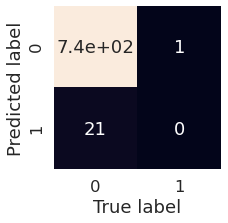

In [48]:
sns.set(font_scale=1.5)

def plot_confusion_mat(Y_test, Y_predict):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_predict), 
                    annot = True,
                    cbar=False)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_confusion_mat(Y_test, Y_predict)    

In [49]:
print(classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       741
           1       0.00      0.00      0.00        21

    accuracy                           0.97       762
   macro avg       0.49      0.50      0.49       762
weighted avg       0.95      0.97      0.96       762



## RandomForest

In [50]:
model1 = RandomForestClassifier(n_estimators=10)

model1 = model1.fit(X_train, Y_train)

model1.score(X_test, Y_test)

0.9711286089238845

In [51]:
cross_val_score(model1, X_test, Y_test, cv=5)

array([0.96732026, 0.97385621, 0.97368421, 0.96710526, 0.98026316])

In [52]:
model1_predict = model1.predict(X_test)

In [53]:
pd.DataFrame(confusion_matrix(Y_test, model1_predict))

,0,1
0,740,1
1,21,0


In [54]:
print(classification_report(Y_test, model1_predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       741
           1       0.00      0.00      0.00        21

    accuracy                           0.97       762
   macro avg       0.49      0.50      0.49       762
weighted avg       0.95      0.97      0.96       762



# Resampling

## Oversampling (resample)

In [55]:
from sklearn.utils import resample

# Concatenate training data back togather
X = pd.concat([X_train, Y_train], axis=1)
X.head()

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,Label
221,81,292.467804,283.668335,287.631134,99021.195312,98395.375000,98692.726562,40.826145,18.888306,25.592831,1
9,50,288.618622,282.704926,286.294952,97805.625000,96094.367188,97054.914062,35.010063,13.019938,21.753832,1
481,124,293.553558,281.030914,286.365265,98894.265625,97843.953125,98486.531250,35.116009,10.270416,22.108883,1
53,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,1
612,144,287.041748,277.368927,282.211304,98925.601562,95370.914062,96993.570312,21.331705,9.840097,16.079870,1


In [56]:
# Seperate minority & majority classes
not_rain = X[X.Label==0]
rain = X[X.Label==1]

In [57]:
not_rain.head()

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,Label
1112,76,287.740723,281.247894,284.629883,99453.476562,97886.117188,98841.398438,17.178600,8.610333,12.324084,0
2293,77,288.434357,278.527557,283.981781,99883.585938,98763.476562,99315.664062,14.932586,8.342566,12.937328,0
1799,88,291.113251,282.159424,286.958740,99500.484375,97678.304688,98497.250000,21.728666,8.453022,13.551085,0
1637,72,285.791809,278.006561,282.103516,99583.554688,96919.570312,98545.531250,24.753384,5.986444,11.168684,0
373,72,289.482178,280.860870,284.815430,100182.835938,99564.632812,99926.007812,22.068027,10.860379,16.149061,0


In [58]:
rain.head()

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,Label
221,81,292.467804,283.668335,287.631134,99021.195312,98395.375000,98692.726562,40.826145,18.888306,25.592831,1
9,50,288.618622,282.704926,286.294952,97805.625000,96094.367188,97054.914062,35.010063,13.019938,21.753832,1
481,124,293.553558,281.030914,286.365265,98894.265625,97843.953125,98486.531250,35.116009,10.270416,22.108883,1
53,72,294.711884,285.905548,289.933289,99743.312500,97501.062500,98391.445312,34.449261,7.907701,19.024771,1
612,144,287.041748,277.368927,282.211304,98925.601562,95370.914062,96993.570312,21.331705,9.840097,16.079870,1


In [59]:
# upsample minority 
rain_upsample = resample(rain,
                         replace=True, # sample with replacement
                         n_samples=len(not_rain), # match number in majority class
                         random_state=27)

In [385]:
rain_upsample.head()

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,Label
465,56,285.918640,280.606995,283.658966,98280.109375,96338.164062,97500.664062,26.568378,7.555609,14.245292,1
427,113,289.027313,281.045197,285.492676,99306.109375,96134.445312,97899.406250,30.679453,7.725224,17.345495,1
401,130,295.581329,284.055023,290.755005,99502.203125,97308.953125,98801.859375,52.266613,11.587915,21.872816,1
132,96,289.366364,282.815521,286.961578,99405.812500,97576.664062,98259.640625,28.990921,9.640429,21.322453,1
59,72,289.050903,279.750671,284.562469,99649.070312,95771.945312,97846.031250,36.879417,7.647168,21.296072,1


In [60]:
# Combine majority and upsampling minority
upsample = pd.concat([not_rain, rain_upsample])
upsample.head()

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,Label
1112,76,287.740723,281.247894,284.629883,99453.476562,97886.117188,98841.398438,17.178600,8.610333,12.324084,0
2293,77,288.434357,278.527557,283.981781,99883.585938,98763.476562,99315.664062,14.932586,8.342566,12.937328,0
1799,88,291.113251,282.159424,286.958740,99500.484375,97678.304688,98497.250000,21.728666,8.453022,13.551085,0
1637,72,285.791809,278.006561,282.103516,99583.554688,96919.570312,98545.531250,24.753384,5.986444,11.168684,0
373,72,289.482178,280.860870,284.815430,100182.835938,99564.632812,99926.007812,22.068027,10.860379,16.149061,0


In [61]:
upsample.Label.value_counts()

0    1729
1    1729
Name: Label, dtype: int64

### Logistic regression with balanced data

In [62]:
y_train = upsample.Label
x_train = upsample.drop('Label', axis=1)

In [63]:
# Model fitting
upsampled_model = LogisticRegression(solver='liblinear').fit(x_train, y_train)

In [64]:
upsampled_pred = upsampled_model.predict(X_test)
upsampled_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,

In [65]:
print(classification_report(Y_test, upsampled_pred))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88       741
           1       0.11      1.00      0.21        21

    accuracy                           0.79       762
   macro avg       0.56      0.89      0.54       762
weighted avg       0.98      0.79      0.86       762



In [66]:
pd.DataFrame(confusion_matrix(Y_test, upsampled_pred))

,0,1
0,579,162
1,0,21


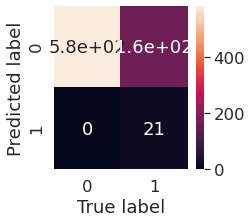

In [67]:
sns.set(font_scale=1.5)

def plot_confusion_mat(Y_test, Y_predict):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_predict), 
                    annot = True,
                    cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_confusion_mat(Y_test, upsampled_pred)   

In [68]:
upsampled_data = pd.DataFrame(upsampled_pred)
upsampled_data[0].value_counts()

0    579
1    183
Name: 0, dtype: int64

### RandomForest

In [69]:
upsampled_model1 = RandomForestClassifier(class_weight={0:1, 1:10}).fit(x_train, y_train)

upsampled_model1_pred = upsampled_model1.predict(X_test)

In [70]:
accuracy_score(Y_test, upsampled_model1_pred)

0.9711286089238845

In [71]:
print(classification_report(Y_test, upsampled_model1_pred ))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       741
           1       0.33      0.05      0.08        21

    accuracy                           0.97       762
   macro avg       0.65      0.52      0.53       762
weighted avg       0.96      0.97      0.96       762



In [72]:
pd.DataFrame(confusion_matrix(Y_test, upsampled_model1_pred))

,0,1
0,739,2
1,20,1


### Decision Tree

In [73]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

clf = clf.fit(x_train, y_train)

clf_pred = clf.predict(X_test)

accuracy_score(Y_test, clf_pred)

0.9461942257217848

In [74]:
pd.DataFrame(confusion_matrix(Y_test, clf_pred))

,0,1
0,720,21
1,20,1


# Penalize Algorithm 

In [75]:
from sklearn.svm import SVC

# we can add class_weight='balanced' to add penalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

In [76]:
svc_model = svc_model.fit(X_train, Y_train)

In [77]:
svc_pred = svc_model.predict(X_test)

In [78]:
pd.DataFrame(confusion_matrix(Y_test, svc_pred))

,0,1
0,741,0
1,21,0


In [79]:
print(classification_report(Y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       741
           1       0.00      0.00      0.00        21

    accuracy                           0.97       762
   macro avg       0.49      0.50      0.49       762
weighted avg       0.95      0.97      0.96       762



/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

## penalize oversampling

In [80]:
svc_model1 = svc_model.fit(x_train, y_train)

In [81]:
svc_pred1 = svc_model1.predict(X_test)

In [82]:
pd.DataFrame(confusion_matrix(Y_test, svc_pred1))

,0,1
0,418,323
1,2,19


# Undersampling

In [83]:
# Downsampling majority
not_rain_downsampling = resample(not_rain,
                                 replace  = False, #sample without replacement
                                 n_samples = len(rain), # match minority n
                                 random_state=27)

In [71]:
#not_rain_downsampling

In [84]:
downsampled = pd.concat([not_rain_downsampling, rain])
downsampled

,Event_duration,temp_max,temp_min,temp_mean,sp_max,sp_min,sp_mean,tcw_max,tcw_min,tcw_mean,Label
2260,48,293.214111,286.794647,290.237061,99770.546875,98949.476562,99252.312500,28.389395,11.961083,18.328384,0
997,98,293.752747,284.718964,288.936462,99022.523438,96717.820312,97813.796875,33.656963,12.076151,20.092499,0
2305,24,291.923492,285.509857,288.774200,99988.195312,99350.015625,99657.968750,22.954298,11.467649,16.502670,0
931,140,295.772461,287.064056,291.267609,99837.273438,98894.085938,99253.265625,33.061954,14.415671,21.801643,0
584,144,294.039948,280.227570,287.436310,99069.945312,96989.296875,97837.046875,26.706694,9.674758,16.240101,0
...,...,...,...,...,...,...,...,...,...,...,...
814,31,291.316040,286.588837,289.237793,99303.921875,98979.812500,99130.015625,35.256756,17.349186,29.034767,1
108,48,292.210663,282.678650,288.992004,98662.062500,97497.789062,97978.109375,27.450247,8.533845,21.354918,1
232,12,282.958984,280.021149,280.923798,98650.273438,98418.164062,98520.609375,15.532563,14.375947,15.046093,1
418,144,286.205444,277.776367,282.226776,98910.617188,95984.414062,97300.125000,25.878344,10.579948,17.375357,1


In [85]:
downsampled.Label.value_counts()

0    48
1    48
Name: Label, dtype: int64

In [86]:
y1_train = downsampled.Label
x1_train = downsampled.drop('Label', axis=1)

In [87]:
undersampled_model = LogisticRegression(solver='liblinear').fit(x1_train, y1_train)

In [88]:
undersampled_pred = undersampled_model.predict(X_test)

In [89]:
accuracy_score(Y_test, undersampled_pred)

0.7664041994750657

In [90]:
print(classification_report(Y_test, undersampled_pred))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86       741
           1       0.10      0.95      0.18        21

    accuracy                           0.77       762
   macro avg       0.55      0.86      0.52       762
weighted avg       0.97      0.77      0.84       762



In [91]:
pd.DataFrame(confusion_matrix(Y_test, undersampled_pred))

,0,1
0,564,177
1,1,20


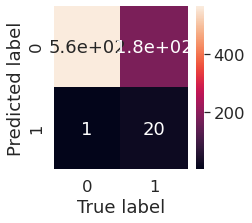

In [92]:
sns.set(font_scale=1.5)

def plot_confusion_mat(Y_test, Y_predict):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_predict), 
                    annot = True,
                    cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_confusion_mat(Y_test, undersampled_pred)  

## RandomForest

In [93]:
undersampled_model1 = RandomForestClassifier().fit(x1_train, y1_train)

y_pred_undersampled_model1 = undersampled_model1.predict(X_test)

pd.DataFrame(confusion_matrix(Y_test, y_pred_undersampled_model1))

,0,1
0,546,195
1,1,20


#  RandomForest with diff oversampling method

In [94]:
# Function to test diff oversampling methods with Randomforest 
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import BorderlineSMOTE
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV


np.random.seed(42)

upsample = {'RandomOverSampler': RandomOverSampler , 
            'SMOTETomek': SMOTETomek, 
            'SMOTEENN' :SMOTEENN, 
            'SMOTE' : SMOTE, 
            'ADASYN': ADASYN,
             'BorderlineSMOTE':BorderlineSMOTE }

grid = {'n_estimators' : [10, 100, 200, 500, 1000, 1200],
       'max_depth' : [None, 5, 10, 20, 30],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6],
       'min_samples_leaf' : [1, 2, 4]}


def over_sample(x_train, y_train, x_test, y_test):
    # Looping methods
    for name, method in upsample.items():
        
        upsam = method()
        
        x_upsam, y_upsam = upsam.fit_resample(x_train, y_train)
        
        model = RandomForestClassifier().fit(x_upsam, y_upsam)
        
        # Setup RandomilzedSearchCV
#         rs_clf1 = RandomizedSearchCV(estimator = clf,
#                            param_distributions=grid,
#                            n_iter=20, # try 20 models total
#                            cv=5 # 5-fold cross-validation
#                              ).fit(x_upsam, y_upsam)

        
        y_pred = model.predict(x_test)
        
        
        print('confusion matrix for ' + str(name))
        print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)))
        print(metrics.classification_report(y_test, y_pred))
#         print(metrics.classification_report(y_test, y_pred_ros))
#         print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred_ros)) )
#         print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred_ros)))
        
        
over_sample(X_train, Y_train, X_test, Y_test)  

confusion matrix for RandomOverSampler
     0  1
0  739  2
1   21  0
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       741
           1       0.00      0.00      0.00        21

    accuracy                           0.97       762
   macro avg       0.49      0.50      0.49       762
weighted avg       0.95      0.97      0.96       762

confusion matrix for SMOTETomek
     0   1
0  703  38
1   11  10
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       741
           1       0.21      0.48      0.29        21

    accuracy                           0.94       762
   macro avg       0.60      0.71      0.63       762
weighted avg       0.96      0.94      0.95       762

confusion matrix for SMOTEENN
     0   1
0  687  54
1   10  11
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       741
           1       0.17      0.52      0

# XGSBoost with different upsample methods

In [97]:
# Function to test diff oversampling methods with Randomforest 
from xgboost.sklearn import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import BorderlineSMOTE
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')



np.random.seed(42)

upsample = {'RandomOverSampler': RandomOverSampler , 
            'SMOTETomek': SMOTETomek, 
            'SMOTEENN' :SMOTEENN, 
            'SMOTE' : SMOTE, 
            'ADASYN': ADASYN,
             'BorderlineSMOTE':BorderlineSMOTE }

grid = {'n_estimators' : [10, 100, 200, 500, 1000, 1200],
       'max_depth' : [None, 5, 10, 20, 30],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6],
       'min_samples_leaf' : [1, 2, 4]}


def over_sample(x_train, y_train, x_test, y_test):
    # Looping methods
    for name, method in upsample.items():
        
        upsam = method()
        
        x_upsam, y_upsam = upsam.fit_resample(x_train, y_train)
        
        model = XGBClassifier().fit(x_upsam, y_upsam)
        
        # Setup RandomilzedSearchCV
#         rs_clf1 = RandomizedSearchCV(estimator = clf,
#                            param_distributions=grid,
#                            n_iter=20, # try 20 models total
#                            cv=5 # 5-fold cross-validation
#                              ).fit(x_upsam, y_upsam)

        
        y_pred = model.predict(x_test)
        
        
        print('confusion matrix for ' + str(name))
        print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred)))
        print(metrics.classification_report(y_test, y_pred))
#         print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred_ros)) )
#         print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred_ros)))
        
        
over_sample(X_train, Y_train, X_test, Y_test)  

[09:20:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix for RandomOverSampler
     0  1
0  733  8
1   19  2
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       741
           1       0.20      0.10      0.13        21

    accuracy                           0.96       762
   macro avg       0.59      0.54      0.56       762
weighted avg       0.95      0.96      0.96       762

[09:20:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd 

# XGBoost Tuning

In [261]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [98]:
smk = SMOTETomek(random_state=42)
x1_upsam, y1_upsam = smk.fit_sample(X_train, Y_train)

model = XGBClassifier().fit(x1_upsam, y1_upsam)
        
y_pred = model.predict(X_test)
        
        
print('confusion matrix for ')
print(pd.DataFrame(metrics.confusion_matrix(Y_test, y_pred)))
print(metrics.classification_report(Y_test, y_pred))
        

[09:22:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix for 
     0   1
0  699  42
1   13   8
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       741
           1       0.16      0.38      0.23        21

    accuracy                           0.93       762
   macro avg       0.57      0.66      0.59       762
weighted avg       0.96      0.93      0.94       762



In [99]:

smk = SMOTETomek(random_state=42)

x1_upsam, y1_upsam = smk.fit_resample(X_train, Y_train)

model = XGBClassifier(learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
       subsample=0.8,
      colsample_bytree=0.8,
      objective= 'binary:logistic',
      nthread=4,
      scale_pos_weight=1,
      seed=27).fit(x1_upsam, y1_upsam)
        
y_pred = model.predict(X_test)
        
        
print('confusion matrix for ' )
print(pd.DataFrame(metrics.confusion_matrix(Y_test, y_pred)))
print(metrics.classification_report(Y_test, y_pred))
#         print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred_ros)) )
#         print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred_ros)))
        
    

[09:24:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix for 
     0   1
0  704  37
1   13   8
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       741
           1       0.18      0.38      0.24        21

    accuracy                           0.93       762
   macro avg       0.58      0.67      0.60       762
weighted avg       0.96      0.93      0.95       762



In [444]:
sm = SMOTETomek()
x1_upsam, y1_upsam = sm.fit_resample(X_train, Y_train)

In [100]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)


model_grid = gsearch1.fit(x1_upsam,y1_upsam)
# gsearch1.best_params_, gsearch1.best_score_

grid_pred = model_grid.predict(X_test)


print(pd.DataFrame(confusion_matrix(Y_test, grid_pred)))
print(classification_report(Y_test, grid_pred))

[09:25:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
     0   1
0  701  40
1   13   8
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       741
           1       0.17      0.38      0.23        21

    accuracy                           0.93       762
   macro avg       0.57      0.66      0.60       762
weighted avg       0.96      0.93      0.94       762



In [101]:
pd.DataFrame(confusion_matrix(Y_test, grid_pred))

,0,1
0,701,40
1,13,8


In [102]:
param_test2 = {
 'max_depth': [4,5,6],
 'min_child_weight':[4,5,6]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)

model_grid1 = gsearch2.fit(x1_upsam, y1_upsam)

model_grid1_predict = model_grid1.predict(X_test)

print(pd.DataFrame(confusion_matrix(Y_test, model_grid1_predict)))
print(classification_report(Y_test, model_grid1_predict))

[09:29:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
     0   1
0  694  47
1   11  10
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       741
           1       0.18      0.48      0.26        21

    accuracy                           0.92       762
   macro avg       0.58      0.71      0.61       762
weighted avg       0.96      0.92      0.94       762



# SMOTE upsample with different ML algorithms

In [103]:
# Function to compute confusion matrices for different ML algorithms using SMOTE upsample 

from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from imblearn.over_sampling import SMOTE

np.random.seed(42)


Algorithms ={"XGBoost" : XGBClassifier,
          "Logisticregression " : LogisticRegression,
          "SVC" : SVC,
           "DecisionTree" : DecisionTreeClassifier,
           "RandomForest" : RandomForestClassifier}

def algorm(X_train, Y_train, X_test, Y_test):
    
    sm = SMOTE(random_state=42)
    x_upsam, y_upsam = sm.fit_sample(X_train, Y_train)

    for name, method in Algorithms.items():
        
        
        model = method()
        model1 = model.fit(x_upsam, y_upsam)
        y_pred = model1.predict(X_test)
        print('confusion matrix for ' + name)
        print(confusion_matrix(Y_test, y_pred))
        print(metrics.classification_report(Y_test, y_pred))
    


algorm(X_train, Y_train, X_test, Y_test)




[09:29:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix for XGBoost
[[705  36]
 [ 14   7]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       741
           1       0.16      0.33      0.22        21

    accuracy                           0.93       762
   macro avg       0.57      0.64      0.59       762
weighted avg       0.96      0.93      0.95       762

confusion matrix for Logisticregression 
[[596 145]
 [  4  17]]
              precision    recall  f1-score   support

           0       0.99      0.80      0.89       741
           1       0.10      0.81      0.19        21

    accuracy                           0.80       762
   macro avg       0

# SMOTEBoost

In [104]:
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

from xgboost.sklearn import XGBClassifier

xgb_model = XGBClassifier()

print(xgb_model.get_xgb_params())



{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [105]:
xgb_model.fit(X_train, Y_train, eval_metric=['error'], eval_set=[(X_train, Y_train), (X_test, Y_test)])

[0]	validation_0-error:0.02363	validation_1-error:0.02625
[1]	validation_0-error:0.02307	validation_1-error:0.02625
[2]	validation_0-error:0.02195	validation_1-error:0.02756
[3]	validation_0-error:0.01913	validation_1-error:0.02887
[4]	validation_0-error:0.01688	validation_1-error:0.02887
[5]	validation_0-error:0.01463	validation_1-error:0.02887
[6]	validation_0-error:0.01294	validation_1-error:0.02887
[7]	validation_0-error:0.01182	validation_1-error:0.02756
[8]	validation_0-error:0.01013	validation_1-error:0.02625
[9]	validation_0-error:0.01013	validation_1-error:0.02625
[10]	validation_0-error:0.01069	validation_1-error:0.02625
[11]	validation_0-error:0.01069	validation_1-error:0.02625
[12]	validation_0-error:0.01013	validation_1-error:0.02756
[13]	validation_0-error:0.00900	validation_1-error:0.02756
[14]	validation_0-error:0.00844	validation_1-error:0.02756
[15]	validation_0-error:0.00844	validation_1-error:0.02756
[16]	validation_0-error:0.00732	validation_1-error:0.02756
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [106]:
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

y_pred = xgb_model.predict(X_test) 
print('confusion matrix')
print(metrics.confusion_matrix(Y_test, y_pred))
print('classification report')
print(metrics.classification_report(Y_test, y_pred))
print('Accuracy')
print(metrics.accuracy_score(Y_test, y_pred))
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, y_pred)))


confusion matrix
[[739   2]
 [ 19   2]]
classification report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       741
           1       0.50      0.10      0.16        21

    accuracy                           0.97       762
   macro avg       0.74      0.55      0.57       762
weighted avg       0.96      0.97      0.96       762

Accuracy
0.9724409448818898
Area under the curve 0.5462695199537305


## XGboost

In [107]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1777, 10), (762, 10), (1777,), (762,))

In [108]:
print(Y_train.value_counts())
print(Y_test.value_counts())

0    1729
1      48
Name: Label, dtype: int64
0    741
1     21
Name: Label, dtype: int64


In [109]:
# upsampling train data
from collections import Counter
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
x_upsam, y_upsam = sm.fit_sample(X_train, Y_train)


In [110]:
y_upsam.value_counts()

0    1729
1    1729
Name: Label, dtype: int64

In [111]:
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')


xgb_model = XGBClassifier()

print(xgb_model.get_xgb_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [112]:
xgb_model.fit(x_upsam, y_upsam)

[09:50:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [113]:
y_pred_upsam = xgb_model.predict(X_test)

print('confusion matrix')
print(pd.DataFrame(metrics.confusion_matrix(Y_test, y_pred_upsam)))
print(metrics.classification_report(Y_test, y_pred_upsam))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, y_pred_upsam)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, y_pred_upsam)))

confusion matrix
     0   1
0  705  36
1   14   7
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       741
           1       0.16      0.33      0.22        21

    accuracy                           0.93       762
   macro avg       0.57      0.64      0.59       762
weighted avg       0.96      0.93      0.95       762

Accuracy 0.9343832020997376
Area under the curve 0.6423751686909581


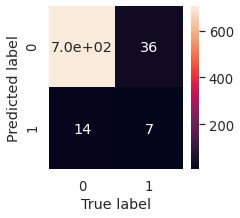

In [114]:
sns.set(font_scale=1.2)

def plot_confusion_mat(Y_test, Y_predict):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_predict), 
                    annot = True,
                    cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_confusion_mat(Y_test, y_pred_upsam) 

## LogisticRegression

In [115]:
# LogisticRegression
model1 = LogisticRegression(solver='liblinear').fit(x_upsam, y_upsam)

y_pred1  = model1.predict(X_test)

print('confusion matrix')
print(pd.DataFrame(metrics.confusion_matrix(Y_test, y_pred1)))
print(metrics.classification_report(Y_test, y_pred1))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, y_pred1)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, y_pred1)))


confusion matrix
     0    1
0  606  135
1    3   18
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       741
           1       0.12      0.86      0.21        21

    accuracy                           0.82       762
   macro avg       0.56      0.84      0.55       762
weighted avg       0.97      0.82      0.88       762

Accuracy 0.8188976377952756
Area under the curve 0.8374783111625217


## SVC

In [116]:
# svc model
from sklearn.svm import SVC


svc_model = SVC()

In [117]:
model5 = svc_model.fit(x_upsam, y_upsam)

y_pred5 = model5.predict(X_test)

print('confusion matrix')
print(metrics.confusion_matrix(Y_test, y_pred5))
print(metrics.classification_report(Y_test, y_pred5))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, y_pred5)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, y_pred5)))

confusion matrix
[[420 321]
 [  2  19]]
              precision    recall  f1-score   support

           0       1.00      0.57      0.72       741
           1       0.06      0.90      0.11        21

    accuracy                           0.58       762
   macro avg       0.53      0.74      0.41       762
weighted avg       0.97      0.58      0.71       762

Accuracy 0.5761154855643045
Area under the curve 0.7357817620975515


## Decision Tree

In [118]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

np.random.seed(42)

dt = DecisionTreeClassifier()

model6 = dt.fit(x_upsam, y_upsam)

y_pred6 = model6.predict(X_test)

print('confusion matrix')
print(metrics.confusion_matrix(Y_test, y_pred6))
print(metrics.classification_report(Y_test, y_pred6))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, y_pred6)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, y_pred6)))

confusion matrix
[[679  62]
 [ 15   6]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       741
           1       0.09      0.29      0.13        21

    accuracy                           0.90       762
   macro avg       0.53      0.60      0.54       762
weighted avg       0.95      0.90      0.92       762

Accuracy 0.8989501312335958
Area under the curve 0.6010217852323115


## RandomForest (best result obtained)

In [119]:
# RandomForest
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

model2 = RandomForestClassifier().fit(x_upsam, y_upsam)

y_pred2 = model2.predict(X_test)

print('confusion matrix')
print(metrics.confusion_matrix(Y_test, y_pred2))
print(metrics.classification_report(Y_test, y_pred2))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, y_pred2)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, y_pred2)))

confusion matrix
[[704  37]
 [ 11  10]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       741
           1       0.21      0.48      0.29        21

    accuracy                           0.94       762
   macro avg       0.60      0.71      0.63       762
weighted avg       0.96      0.94      0.95       762

Accuracy 0.937007874015748
Area under the curve 0.713128976286871


In [120]:
model2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Hyperparameter tunning (RandomForest)

#### Randomizedsearchcv

In [121]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(42)

# Hyperparameter grid RandomizedSearchCV will search over
grid = {'n_estimators' : [10, 100, 200, 500, 1000, 1200],
       'max_depth' : [None, 5, 10, 20, 30],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6],
       'min_samples_leaf' : [1, 2, 4]}

clf = RandomForestClassifier(n_jobs=1)

# Setup RandomilzedSearchCV
rs_clf = RandomizedSearchCV(estimator = clf,
                           param_distributions=grid,
                           n_iter=2, # try 20 models total
                           cv=2 # 5-fold cross-validation
                             ) 


# Fit the RandomizedSearchCV version of clf
rs_clf.fit(x_upsam, y_upsam)

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=1), n_iter=2,
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 1200]})

In [122]:
# Make predictions with the best hyperparamters
rs_y_pred = rs_clf.predict(X_test)

print('confusion matrix')
print(metrics.confusion_matrix(Y_test, rs_y_pred))
print(metrics.classification_report(Y_test, rs_y_pred))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, rs_y_pred)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, rs_y_pred)))

confusion matrix
[[707  34]
 [ 13   8]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       741
           1       0.19      0.38      0.25        21

    accuracy                           0.94       762
   macro avg       0.59      0.67      0.61       762
weighted avg       0.96      0.94      0.95       762

Accuracy 0.9383202099737533
Area under the curve 0.6675342201657991


In [123]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(42)

# Hyperparameter grid RandomizedSearchCV will search over
grid = {'n_estimators' : [10, 100, 200, 500, 1000, 1200],
       'max_depth' : [None, 5, 10, 20, 30],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6],
       'min_samples_leaf' : [1, 2, 4]}

clf = RandomForestClassifier(n_jobs=1)

# Setup RandomilzedSearchCV
rs_clf1 = RandomizedSearchCV(estimator = clf,
                           param_distributions=grid,
                           n_iter=20, # try 20 models total
                           cv=5 # 5-fold cross-validation
                             ) 


# Fit the RandomizedSearchCV version of clf
rs_clf1.fit(x_upsam, y_upsam)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1), n_iter=20,
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 1200]})

In [124]:
rs_clf1.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20}

In [125]:
# Make predictions with the best hyperparamters
rs_y_pred1 = rs_clf1.predict(X_test)

print('confusion matrix')
print(metrics.confusion_matrix(Y_test, rs_y_pred1))
print(metrics.classification_report(Y_test, rs_y_pred1))
print('Accuracy {}'.format(metrics.accuracy_score(Y_test, rs_y_pred1)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(Y_test, rs_y_pred1)))

confusion matrix
[[705  36]
 [ 12   9]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       741
           1       0.20      0.43      0.27        21

    accuracy                           0.94       762
   macro avg       0.59      0.69      0.62       762
weighted avg       0.96      0.94      0.95       762

Accuracy 0.937007874015748
Area under the curve 0.6899942163100058


# Cross validation

In [129]:
# To divide data into train, valild and test
np.random.seed(42)

#Split the data into train, validation & test sets
#train_split = round(0.5 * len(train_data)) # 50% of train data
valid_split = round(0.15*len(test_data)) # 15% of test data

#X_train, Y_train = X[:train_split], Y[:train_split]
x_valid, y_valid = X_test[:valid_split], Y_test[:valid_split]
x_test, y_test = X_test[valid_split:], Y_test[valid_split:]

# Fit the model


In [130]:
# To get the same split each time
kf = KFold(n_splits=5, shuffle=False)

In [131]:
#x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42)

rf = RandomForestClassifier(random_state=42)

cross_val_score(rf, X_train, Y_train, cv=kf, scoring='recall')

array([0., 0., 0., 0., 0.])

In [132]:
params = {'n_estimators' : [500, 1000, 2000],
         #'max_dept' : [4, 65, 10, 12],
         'random_state' :[42]}

grid1 = {'n_estimators' : [10, 100, 200, 500, 1000, 1200, 1500, 2000, 2200, 2500],
       'max_depth' : [None, 5, 10, 20, 30, 50, 70, 100],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6, 8, 10],
       'min_samples_leaf' : [1, 2, 4],
       'bootstrap' : [True, False]}

grid_no_up = GridSearchCV(rf, param_grid=params, cv=kf, scoring='recall').fit(X_train, Y_train)

In [133]:
grid_no_up.best_score_

0.0

In [134]:
y_pred = grid_no_up.predict(x_test)
confusion_matrix(y_test, y_pred)


array([[648]])

## oversample

In [135]:
x_train_up, y_train_up = SMOTE(random_state=42).fit_sample(X_train, Y_train)

In [136]:


grid_naive_up = GridSearchCV(rf, param_grid=params, cv=kf, scoring='recall').fit(x_train_up, y_train_up)

grid_naive_up.best_score_

0.774784193815371

In [137]:
y_pred_up = grid_naive_up.predict(x_test)

print(confusion_matrix(y_test, y_pred_up))
print(classification_report(y_test, y_pred_up))

[[623  25]
 [  0   0]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       648
           1       0.00      0.00      0.00         0

    accuracy                           0.96       648
   macro avg       0.50      0.48      0.49       648
weighted avg       1.00      0.96      0.98       648



In [138]:
y_train_up.value_counts()

0    1729
1    1729
Name: Label, dtype: int64

In [139]:
y_train.value_counts()

0    1729
1    1729
Name: Label, dtype: int64